# Introduction
I constructed this Kernel from [MichaelMayer](https://www.kaggle.com/mayer79)'s great [RNN Starter Kernel](https://www.kaggle.com/mayer79/rnn-starter/code) code. Thanks for that! I've been using a similar Kernel with a Notebook but it's got plenty of other stuff in there which makes it more than just bare bones. Since this is not really my work, I figured I would share this Kernel with the community. It's meant to be MichaelMayer's starter code converted to a Notebook and nothing more. I had to make some changes, which I've indicated in the code.

# Basic idea of the Kernel
At test time, we will see a time series x of length 150 000 to predict the next earthquake. The idea of this kernel is to split x into contiguous chunks of size 1000 and feed summary statistics calculated from these chunks into a current neural net with 150 000 / 1000 = 150 time steps. 

# Validation
Validation is a very complex and crucial element of this competition. Here, the validation generator is fed with data until the second earthquake, while the training generator solely picks chunks after the second earthquake. In order to reach a better LB score, you will need to change this so that the training generator has access to the full data.

# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

from tqdm import tqdm

# Any results you write to the current directory are saved as output.

['test', 'train.csv', 'sample_submission.csv']


# Setup

In [2]:
# Fix seeds
from numpy.random import seed
seed(639)
from tensorflow import set_random_seed
set_random_seed(5944)

float_data = pd.read_csv("../input/train.csv", dtype={"acoustic_data": np.float32, "time_to_failure": np.float32}).values

# Helper functions
## Helper function for data generator
Extracts mean, standard deviation, and quantiles per time step.
Can easily be extended. Expects a two dimensional array.

In [3]:
def extract_features(z):
     return np.c_[z.mean(axis=1), np.transpose(np.percentile(np.abs(z), q=[0,25, 50, 75, 100], axis=1)),z.std(axis=1),
                 np.abs(z).mean(axis=1),np.abs(z).std(axis=1),np.transpose(np.percentile(z, q=[0,25, 50, 75, 100], axis=1))]

## Create features
For a given ending position "last_index", we split the last 150 000 values of *x* into 150 pieces of length 1000 each. So *n_steps * step_length* should equal 150 000.
From each piece, a set features are extracted. This results in a feature matrix of dimension *(150 time steps x features)*.  

In [4]:
def create_X(x, last_index=None, n_steps=150, step_length=1000): #modify different conbinations
    if last_index == None:
        last_index=len(x)
       
    assert last_index - n_steps * step_length >= 0

    # Reshaping and approximate standardization with mean 5 and std 3.
    # ORIGINAL: I changed this becuase I got an No OpKernel was registered to support Op 'CudnnRNN' error
    #temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1) - 5 ) / 3
    # MY CHANGE: This doesn't fix things, I get the same errors
    temp = (x[(last_index - n_steps * step_length):last_index].reshape(n_steps, -1).astype(np.float32) - 5 ) / 3
    
    # Extracts features of sequences of full length 1000, of the last 100 values and finally also 
    # of the last 10 observations. 
    return np.c_[extract_features(temp),
                 extract_features(temp[:, -step_length // 10:]),
                 extract_features(temp[:, -step_length // 100:]),
                 extract_features(temp[:, 0:step_length // 10]),
                 extract_features(temp[:, 0:step_length // 100])]

## Generate features

In [5]:
# Query "create_X" to figure out the number of features
n_features = create_X(float_data[0:150000]).shape[1]
print("Our RNN is based on %i features"% n_features)
    
# The generator endlessly selects "batch_size" ending positions of sub-time series. For each ending position,
# the "time_to_failure" serves as target, while the features are created by the function "create_X".
def generator(data, min_index=0, max_index=None, batch_size=16, n_steps=150, step_length=1000):
    if max_index is None:
        max_index = len(data) - 1
     
    while True:
        # Pick indices of ending positions
        rows = np.random.randint(min_index + n_steps * step_length, max_index, size=batch_size)
         
        # Initialize feature matrices and targets
        samples = np.zeros((batch_size, n_steps, n_features))
        targets = np.zeros(batch_size, )
        
        for j, row in enumerate(rows):
            samples[j] = create_X(data[:, 0], last_index=row, n_steps=n_steps, step_length=step_length)
            targets[j] = data[row - 1, 1]
        yield samples, targets
        
batch_size = 32

# Position of second (of 16) earthquake. Used to have a clean split
# between train and validation
second_earthquake = 50085877
float_data[second_earthquake, 1]

# Initialize generators
# train_gen = generator(float_data, batch_size=batch_size) # Use this for better score
train_gen = generator(float_data, batch_size=batch_size, min_index=second_earthquake + 1)
valid_gen = generator(float_data, batch_size=batch_size, max_index=second_earthquake)


Our RNN is based on 70 features


# Define the model

In [6]:
from keras.models import Sequential
from keras.layers import Dense, CuDNNGRU,CuDNNLSTM
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import keras

cb = [ModelCheckpoint("model.hdf5", save_best_only=True, period=5)]

model = Sequential()
model.add(CuDNNLSTM(48, input_shape=(None, n_features)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48)                23040     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                490       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 23,651
Trainable params: 23,651
Non-trainable params: 0
_________________________________________________________________


# Compile and fit model

In [7]:
model.compile(optimizer=adam(lr=0.0005), loss="mae") 

history = model.fit_generator(train_gen,
                              steps_per_epoch=1000,
                              epochs=40,
                              verbose=0,
                              callbacks=cb,
                              validation_data=valid_gen,
                              validation_steps=200)

# history = model.fit_generator(train_gen,
#                               steps_per_epoch=1000,
#                               epochs=60,
#                               verbose=0,
#                               callbacks=cb)

Instructions for updating:
Use tf.cast instead.


# Visualize accuracies

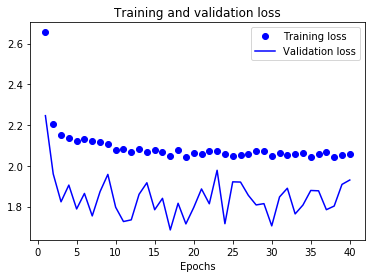

In [8]:
import matplotlib.pyplot as plt

def perf_plot(history, what = 'loss'):
    x = history.history[what]
    val_x = history.history['val_' + what]
    epochs = np.asarray(history.epoch) + 1
    
    plt.plot(epochs, x, 'bo', label = "Training " + what)
    plt.plot(epochs, val_x, 'b', label = "Validation " + what)
    plt.title("Training and validation " + what)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return None

perf_plot(history)

# Load submission file

In [9]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

## Prepare submission data
Load each test data, create the feature matrix, get numeric prediction


In [10]:
for i, seg_id in enumerate(tqdm(submission.index)):
  #  print(i)
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    submission.time_to_failure[i] = model.predict(np.expand_dims(create_X(x), 0))

submission.head()

100%|██████████| 2624/2624 [01:30<00:00, 29.14it/s]


,time_to_failure
seg_id,
seg_00030f,3.103065
seg_0012b5,4.972178
seg_00184e,5.755177
seg_003339,8.142811
seg_0042cc,6.146500


## Save submission file

In [11]:
submission.to_csv('submission.csv')